#### Create a Jupyter Conda Environment 
source activate myenv
python -m ipykernel install --user --name myenv --display-name "Python (myenv)"

In [1]:
import warnings
import PyPDF2
import textract
import nltk, re, pprint
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec
from matplotlib import pyplot
import spacy
import io
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

In [4]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, password="", caching=True, check_extractable=True):
            page_interpreter.process_page(page)
            
        text = fake_file_handle.getvalue()
    
    # close open handles
    converter.close()
    fake_file_handle.close()
    
    if text:
        return text

In [ ]:
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

def extract_text_by_page(pdf_path):
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            resource_manager = PDFResourceManager()
            fake_file_handle = io.StringIO()
            converter = TextConverter(resource_manager, fake_file_handle)
            page_interpreter = PDFPageInterpreter(resource_manager, converter)
            page_interpreter.process_page(page)
            
            text = fake_file_handle.getvalue()
            yield text
    
            # close open handles
            converter.close()
            fake_file_handle.close()
    
def extract_text(pdf_path):
    for page in extract_text_by_page(pdf_path):
        print(page)
        print()
        
if __name__ == '__main__':
    print(extract_text('w9.pdf'))

In [3]:
CVA_proposal = '/Users/michael/Accounts/Wellesley/CVA-Proposal.pdf'
# cva_text = extract_text_from_pdf(CVA_proposal)
cva_text = textract.process(CVA_proposal).decode()

In [4]:
# print(repr(text[:50]))
print(cva_text[:1000])

THIS DOCUMENT IS IMPORTANT AND REQUIRES YOUR IMMEDIATE ATTENTION. If you are in
any doubt as to the action you should take, you are recommended to seek your own independent
advice from a solicitor, or independent financial advice from an accountant or financial adviser.
This document does not constitute or form any part of any offer or invitation to sell or issue, or any
solicitation of any offer to acquire any Shares or other transferable securities in Wellesley Finance Plc
or the Group except as provided for in Clauses 7, 8, 9 and 10 of Part V of the Proposal. Any reproduction
of this document, in whole or in part, and any disclosure of its contents, except to the extent such
information is otherwise publicly available or use of any information it contains for any purpose other
than considering the resolutions, is prohibited.
Wellesley Finance Plc (the “Company”)
and
each of its CREDITORS (as defined herein)
COMPANY VOLUNTARY ARRANGEMENT
(under Part I of the Insolvency Act 1986 and P

In [6]:
# cvafile = '/Users/michael/Accounts/Wellesley/CVA-Proposal.txt'
# file = open(cvafile, 'r')
# cva_text = file.read()

In [5]:
def chomp(x):
    if x.endswith("\r\n"): return x[:-2]
    if x.endswith("\n") or x.endswith("\r"): return x[:-1]
    return x

In [6]:
def tokenize(text):
    r = re.compile(r"\.?\d*.\d*.\d*\.?\b")
    text = re.sub(r'-\n(\w+ *)', r'\1', text)
    punctuation = ['(',')',';',':','[',']',',', '-', '/']
    stop_words = stopwords.words('english')
    non_words = ['...', '..', '.']
    tokens = word_tokenize(text)
    keywords = [word.lower() for word in tokens 
                if not word in stop_words 
                and not word in punctuation 
                and word not in non_words
                and not r.match(word)
                and not word.startswith('................')                
                and len(word) > 3]
    return keywords

In [7]:
def join_split_words(text):
    return re.sub(r'-\n(\w+ *)', r'\1', text)

In [8]:
def clean_sentences(pageText):
    punctuation = ['(',')',';',':','[',']',',', '-', '/']
    stop_words = stopwords.words('english')
    non_words = ['...', '..', '.', '']
    r = re.compile(r"\.?\d*.\d*.\d*\.?\b")
    pageText = join_split_words(pageText)
    sentences = pageText.split('\n')
#     sentences = nltk.sent_tokenize(pageText)
#     sentences = split_sentences(pageText)
#     doc = nlp(pageText)
#     sentences = doc.sents
    sentences = [word for word in sentences if len(word.strip()) > 0]
    cleanedSentences = [word.strip() for word in sentences 
                if not word in stop_words 
                and not word in punctuation 
                and word not in non_words
                and not r.match(word)
                and not 'CONTENT' in word
                and not '................' in word
                and len(word) > 3
    ]
    return cleanedSentences

In [9]:
def join_sentences(sentences):
    for index, sentence in enumerate(sentences):
        tokens = sentence.split()
        if len(tokens) > 0 and len(tokens) < 6:
            preceeding = sentences[index-1]
            if len(preceeding.split()) == 0:
                preceeding = sentences[index-2]
            preceeding = preceeding + ' ' + sentence
            sentences[index-1] = preceeding.strip()
            sentences[index] = ''
    sentences = [sen for sen in sentences if len(sen) > 0]
    return sentences

In [10]:
cva_sentences = clean_sentences(cva_text)

In [46]:
print(len(cva_sentences))
print(cva_sentences[:10])

20764
['THIS DOCUMENT IS IMPORTANT AND REQUIRES YOUR IMMEDIATE ATTENTION. If you are in', 'any doubt as to the action you should take, you are recommended to seek your own independent', 'advice from a solicitor, or independent financial advice from an accountant or financial adviser.', 'This document does not constitute or form any part of any offer or invitation to sell or issue, or any', 'solicitation of any offer to acquire any Shares or other transferable securities in Wellesley Finance Plc', 'information is otherwise publicly available or use of any information it contains for any purpose other', 'than considering the resolutions, is prohibited.', 'Wellesley Finance Plc (the “Company”)', 'each of its CREDITORS (as defined herein)', 'COMPANY VOLUNTARY ARRANGEMENT']


In [12]:
# cva_sentences = join_sentences(cva_sentences)

In [19]:
cva_cleaned_text = ' '.join(cva_sentences)

In [20]:
cva_cleaned_text[:500]

'THIS DOCUMENT IS IMPORTANT AND REQUIRES YOUR IMMEDIATE ATTENTION. If you are in any doubt as to the action you should take, you are recommended to seek your own independent advice from a solicitor, or independent financial advice from an accountant or financial adviser. This document does not constitute or form any part of any offer or invitation to sell or issue, or any solicitation of any offer to acquire any Shares or other transferable securities in Wellesley Finance Plc information is other'

In [21]:
cva_cleaned_text.find('Key Dates')

9158

In [45]:
cva_cleaned_text.find('none')

189283

In [22]:
len(cva_text)

658581

In [23]:
len(cva_cleaned_text)

383880

In [63]:
r = re.compile(r"\.?\d*.\d*.\d*\.?\b")
punctuation = ['(',')',';',':','[',']',',', '-', '/']
stop_words = stopwords.words('english')
non_words = ['...', '..', '.']
exclusions = ['none', 'signature_______________________', '_______________']

In [24]:
tokens = word_tokenize(cva_cleaned_text)

In [35]:
len(tokens)

58692

In [64]:
keywords = [word.lower() for word in tokens 
            if not word.lower() in stop_words 
            and not word in punctuation 
            and word not in non_words
            and word.lower() not in exclusions
            and not r.match(word)
            and not word.startswith('................')            
            and len(word) > 3]

In [65]:
print(len(keywords))
keywords[:10]

26758


['document',
 'important',
 'requires',
 'immediate',
 'attention',
 'doubt',
 'action',
 'take',
 'recommended',
 'seek']

In [66]:
counter = Counter(keywords)
print(len(counter.items()))
most_common = [pair[0] for pair in counter.most_common()]
most_common[:10]

2438


['confidential',
 'company',
 'creditors',
 'loan',
 'creditor',
 'shall',
 'proposal',
 'book',
 'loans',
 'means']

In [67]:
nltk_text = nltk.Text(keywords)

In [68]:
print(type(nltk_text))
print(len(nltk_text))

<class 'nltk.text.Text'>
26758


In [69]:
nltk_text

<Text: document important requires immediate attention doubt action take...>

In [70]:
nltk_text.collocations()

confidential confidential; loan book; preferred shares; book sale;
year year; payment fund; duff phelps; effective date; bond
documentation; compromised creditors; third party; listed bondholders;
decision procedure; wellesley finance; voluntary arrangement; amount
equivalent; allowed claim; security trustee; insolvency rules; england
wales


In [71]:
nltk_text.concordance('loan', width=110, lines=50, )

Displaying 50 of 285 matches:
ates expected timetable events event date completion loan book sale dispatch proposal documents notice decisio
rs created significant unanticipated funding company loan book requiring around funding developments completed
mpacted ability certain borrowers service respective loan commitments turn created additional cashflow issues 
nts relation loans would present options either wind loan book sell loan book distressed basis company markete
ans would present options either wind loan book sell loan book distressed basis company marketed loan book sal
ook sell loan book distressed basis company marketed loan book sale following completion marketing process loa
oan book sale following completion marketing process loan book ultimately sold cloverleaf terms loan book sale
g process loan book ultimately sold cloverleaf terms loan book sale provide sale consideration distributed var
d within security trust agreement proceeds available loan book sale company make d

In [72]:
fdist = nltk.FreqDist(keywords)

In [73]:
fdist.most_common()[-10:]

[('reduce', 1),
 ('served', 1),
 ('vacate', 1),
 ('occupation', 1),
 ('serviced', 1),
 ('showing', 1),
 ('forecasts', 1),
 ('line', 1),
 ('overleaf', 1),
 ('postcode', 1)]

In [74]:
fdist.most_common(20)

[('confidential', 8474),
 ('company', 705),
 ('creditors', 549),
 ('loan', 285),
 ('creditor', 218),
 ('shall', 180),
 ('proposal', 172),
 ('book', 170),
 ('loans', 152),
 ('means', 145),
 ('supervisors', 138),
 ('claim', 129),
 ('sale', 128),
 ('shares', 121),
 ('terms', 121),
 ('claims', 118),
 ('payment', 117),
 ('directors', 105),
 ('compromised', 102),
 ('would', 94)]

In [75]:
most_common_words = [pair[0] for pair in fdist.most_common(20)]

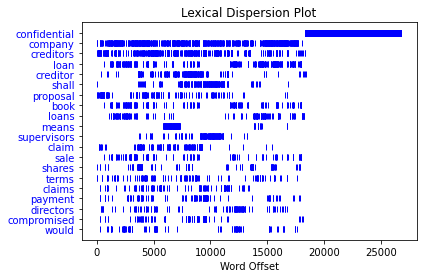

In [76]:
nltk_text.dispersion_plot(most_common_words)

In [77]:
for word in sorted(fdist):
    if (fdist[word]) > 0:
        print(word, '->', fdist[word], end='; ')

/surplus -> 5; ability -> 8; able -> 31; abovementioned -> 1; abrogated -> 1; absence -> 3; absolute -> 4; absolutely -> 2; abstract -> 1; accept -> 2; acceptance -> 2; accepted -> 12; accepting -> 1; accepts -> 1; access -> 13; accompanied -> 3; accordance -> 68; according -> 4; accordingly -> 16; account -> 19; accountant -> 6; accountants -> 1; accounting -> 1; accounts -> 5; accruals -> 4; accrued -> 3; accuracy -> 2; accustomed -> 1; achievable -> 1; achieve -> 9; achieved -> 7; acknowledgements -> 1; acknowledges -> 2; acquire -> 2; acquired -> 4; acquiring -> 2; acquisition -> 3; acquisitions -> 1; acquitted -> 1; across -> 3; acted -> 2; acting -> 12; action -> 25; actions -> 3; activities -> 5; activity -> 1; acts -> 10; actual -> 7; acute -> 1; added -> 4; addition -> 5; additional -> 7; additionally -> 2; address -> 16; addressed -> 2; addressee -> 1; addresses -> 3; addressing -> 2; adequate -> 1; adjacencies -> 1; adjusted -> 6; adjustment -> 3; administer -> 2; administer

1; direction -> 2; directions -> 2; directly -> 5; director -> 7; directors -> 105; directs -> 2; disbursements -> 6; discharge -> 1; discharged -> 6; discharges -> 1; discharging -> 6; disclaimer -> 2; disclose -> 1; disclosure -> 1; discontinue -> 1; discount -> 3; discounted -> 1; discounts -> 1; discretion -> 11; discretionary -> 4; discretions -> 2; disease -> 1; disordered -> 1; disorderly -> 1; dispatch -> 1; disposal -> 4; dispose -> 1; disposed -> 1; dispute -> 1; disputed -> 13; disputes -> 1; disregarded -> 2; disseminated -> 1; distinguished -> 1; distressed -> 3; distributable -> 6; distribute -> 2; distributed -> 5; distribution -> 15; distributions -> 5; disturb -> 1; dividend -> 3; document -> 16; documentary -> 1; documentation -> 93; documents -> 21; done -> 2; dormant -> 2; doubt -> 9; downside -> 1; downstream -> 1; dramatic -> 1; dramatically -> 1; drawdown -> 2; drawdowns -> 1; drawn -> 5; duff -> 21; duffandphelps.com -> 8; duly -> 3; duration -> 2; duties -> 6; 

; matures -> 2; maturing -> 1; maturities -> 4; maturity -> 7; maximise -> 3; maximising -> 1; maximum -> 1; may-21 -> 1; may-22 -> 1; may-23 -> 1; may-24 -> 1; mean -> 3; meaning -> 17; meanings -> 2; means -> 145; measure -> 1; meet -> 12; meeting -> 32; meetings -> 3; meets -> 1; member -> 2; members -> 4; memorandum -> 1; mentally -> 1; mentioned -> 3; method -> 1; methodology -> 2; mid-build -> 1; mid-june -> 1; mid-market -> 1; mid-rate -> 1; might -> 1; milestones -> 2; mills -> 2; mini -> 24; mini-bond -> 5; mini-bonds -> 6; minibond -> 4; minibonds -> 3; minimum -> 2; minority -> 1; miscalculation -> 1; miscellaneous -> 1; mismatch -> 5; mitigate -> 1; mixture -> 2; model -> 12; models -> 1; modest -> 1; modification -> 12; modifications -> 5; modified -> 3; modify -> 1; money -> 5; monies -> 12; month -> 2; monthly -> 5; months -> 8; moratorium -> 1; mortgage -> 2; mortgages -> 1; mostly -> 1; move -> 2; moved -> 1; movement -> 1; movements -> 1; moving -> 1; much -> 1; multi

93; security…on -> 1; seeing -> 1; seek -> 10; seeking -> 2; seeks -> 2; seen -> 1; sees -> 1; segregated -> 2; selected -> 1; selection -> 1; self-help -> 3; sell -> 14; selling -> 8; send -> 4; sending -> 3; sends -> 1; senior -> 8; sent -> 19; sep-20 -> 1; sep-21 -> 1; sep-22 -> 1; sep-23 -> 1; separate -> 1; separately -> 1; september -> 28; series -> 25; served -> 1; service -> 11; serviced -> 1; servicer -> 24; services -> 10; servicing -> 24; set-off -> 7; sets -> 1; settle -> 4; settled -> 5; settlement -> 16; seven -> 4; seventy -> 4; seventy-five -> 1; seventy-three -> 2; several -> 3; severally -> 2; severance -> 1; severe -> 2; shall -> 180; shard -> 5; share -> 23; shared -> 1; shareholder -> 62; shareholders -> 7; shareholding -> 6; shareholdings -> 1; shares -> 121; sheet -> 14; shoosmiths -> 2; short -> 4; short-term -> 1; shortage -> 1; shorter -> 2; shortfall -> 19; showing -> 1; shown -> 4; shows -> 2; shut -> 1; sign -> 1; signatory -> 1; signature -> 1; signed -> 8

In [64]:
# model = Word2Vec(prin_pages, min_count=10)
# model = Word2Vec(prin_pages)

In [78]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [79]:
from gensim.models.phrases import Phrases, Phraser

In [80]:
sent = [row.split() for row in cva_sentences]

In [81]:
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [82]:
model = Word2Vec(
        sentences,
        size=150,
        window=10,
        min_count=2,
        workers=10,
        iter=10)

In [83]:
# print(model)
words = list(model.wv.vocab)
print(words)

['THIS', 'IS', 'IMPORTANT', 'AND', 'If', 'you', 'are', 'in', 'any', 'doubt', 'as', 'to', 'the', 'action', 'should', 'seek', 'your', 'own', 'independent', 'advice', 'from', 'a', 'or', 'financial', 'an', 'accountant', 'This', 'document', 'does', 'not', 'constitute', 'form', 'part', 'of', 'offer', 'invitation', 'sell', 'acquire', 'Shares', 'other', 'securities', 'Wellesley', 'Finance', 'Plc', 'information', 'is', 'otherwise', 'available', 'use', 'it', 'contains', 'for', 'purpose', 'than', 'considering', '(the', 'each', 'its', 'CREDITORS', '(as', 'defined', 'COMPANY', 'VOLUNTARY', 'ARRANGEMENT', 'Part', 'I', 'Insolvency', 'Act', '1986', 'and', 'II', '(England', 'Wales)', 'Rules', 'has_been', 'prepared', 'solely', 'inform', 'Creditors', 'Shareholder', 'proposal', 'purpose.', 'Your', 'attention', 'drawn', 'Clause', '1', 'Section', '2', '(Terms', 'Proposal).', 'V', 'Company', 'Voluntary', 'Arrangement)', 'such', 'shall', 'apply', 'throughout', 'this', 'document,', 'Paragraphs', '7', 'Proposal

In [84]:
print(model['insolvency'])

[ 0.09165251  0.18338494  0.00745261 -0.04418386  0.049078   -0.15573812
  0.07343958  0.03635622  0.22324526  0.01086114 -0.16443168  0.0980593
 -0.16045189 -0.05195812 -0.10055547 -0.09431712  0.11293712  0.04021747
 -0.08670371 -0.06361161 -0.03803863  0.00731208 -0.01582636 -0.0997011
  0.12652956  0.0261711   0.00520666  0.02680101  0.008246    0.06683809
  0.04667078 -0.083216    0.09303798  0.03915379  0.01496906  0.09002834
 -0.03952529 -0.0197845  -0.07450879 -0.14202958 -0.07638787  0.1327137
 -0.09376112  0.00168905  0.03449083  0.00434552 -0.01974448  0.03803587
  0.08600284  0.02362485 -0.04875352  0.10361117  0.00218004  0.34817803
  0.12860712  0.06769752 -0.06728518  0.01487229 -0.04821877 -0.10395019
  0.01748659  0.09076227 -0.14897135  0.07835978 -0.04795072 -0.03296508
  0.10316747  0.01611372 -0.03316852  0.06377397  0.07470201 -0.03477973
  0.00438921 -0.05798738  0.03982405  0.15705648 -0.05264264 -0.07130665
  0.05132092 -0.01636556 -0.05777656  0.00483081 -0.13

In [85]:
vocab_item =  model.wv.vocab['insolvency']
vocab_item.count

9

In [92]:
pyplot.rcParams["figure.figsize"] = 20,15

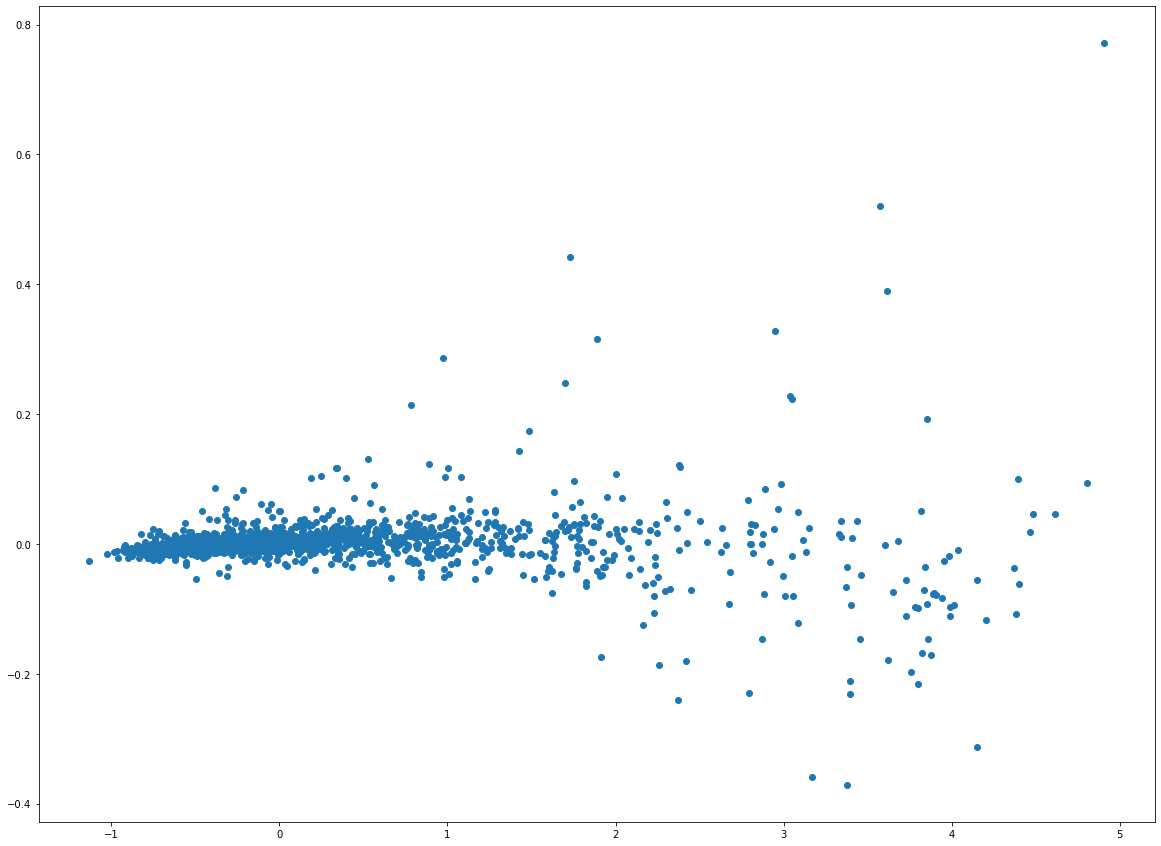

In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = model[model.wv.vocab]
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
pyplot.show()

In [88]:
model.similarity('insolvency', 'Wellesley')

0.9937402

In [89]:
model.most_similar(negative=['insolvency'])

[('elects', 0.9842296838760376),
 ('pre-emption', 0.9683405160903931),
 ('contemplation', 0.9321544170379639),
 ('contents', 0.8881635665893555),
 ('comparison', 0.81573486328125),
 ('realisable', 0.30728450417518616),
 ('matched.', 0.17032268643379211),
 ('Less:', 0.09950227290391922),
 ('Appointment', 0.08559703826904297),
 ('Definitions', 0.068052276968956)]

In [90]:
model.most_similar(positive=['insolvency'])

[('intercompany', 0.9997203946113586),
 ('funding', 0.9997180700302124),
 ('these', 0.9997178316116333),
 ('shares', 0.9997144937515259),
 ('cash', 0.9997044801712036),
 ('been', 0.9997038841247559),
 ('than', 0.9997025728225708),
 ('further', 0.9997003078460693),
 ('were', 0.9996948838233948),
 ('property', 0.9996928572654724)]

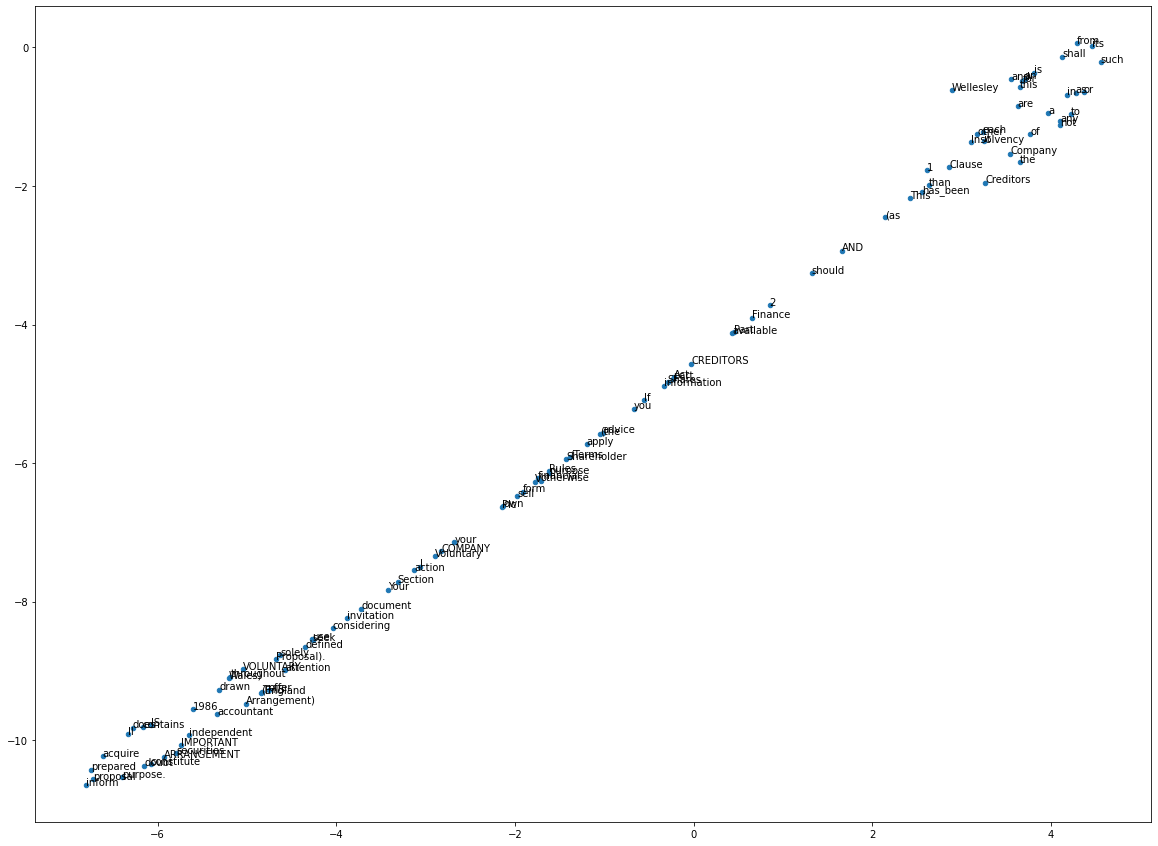

In [91]:
import numpy as np
labels = []
count = 0
max_count = 100
X = np.zeros(shape=(max_count,len(model['insolvency'])))

for term in list(model.wv.vocab):
    X[count] = model[term]
    labels.append(term)
    count+= 1
    if count >= max_count: break

# It is recommended to use PCA first to reduce to ~50 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)

# Show the scatter plot
import matplotlib.pyplot as plt
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

plt.show()